In [701]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [702]:
set_should_stop(True)

In [710]:
paths = glob.glob(f"{BLENDER_MEMBANK_ROOT}/**/obs_per_sec.npy", recursive=True)
obs_per_sec = np.array([np.load(p)[0] for p in paths])
obs_per_sec

array([ 4.932573 ,  9.753356 ,  7.958496 ,  4.890314 ,  5.0536785,
        8.378085 ,  9.850855 ,  7.435262 ,  6.8414392,  8.102805 ,
        5.915898 , 11.071383 ], dtype=float32)

In [685]:
chunks_range = range(SEQ_LEN-1, EPISODE_LEN, SEQ_LEN)

In [686]:
run_paths = glob.glob("/home/beans/blender_membank/*/run*", recursive=True)

In [687]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in chunks_range], axis=0)
maps = np.concatenate([np.load(f'{run_path}/maps_{i}.npy') for i in chunks_range], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct
#maps[:-1,:,:,:] = maps[1:,:,:,:]

targets_all = targets
targets, wp_dists, wp_z = np.split(targets_all, 3, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, maps.shape, run_path

((1160, 5),
 (1160, 30),
 (1160, 30),
 (1160, 30),
 (1160, 120, 80, 3),
 '/home/beans/blender_membank/dataloader_11/run_0')

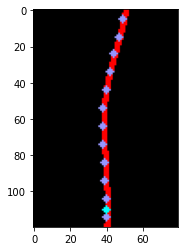

In [688]:
plt.imshow(maps[550])

In [689]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

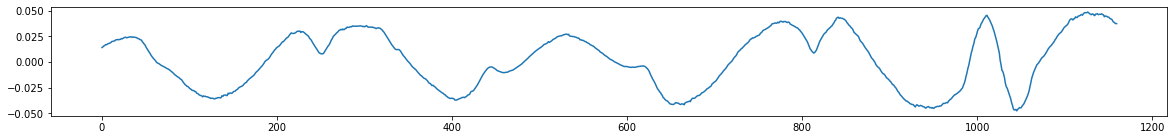

In [690]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

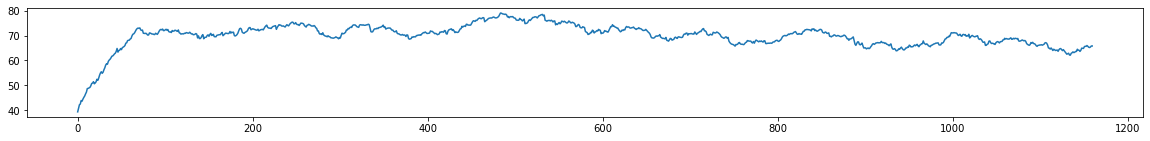

In [691]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [692]:
ix = 1000

In [693]:
t = smooth_near_wps(targets[ix])

In [694]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [695]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

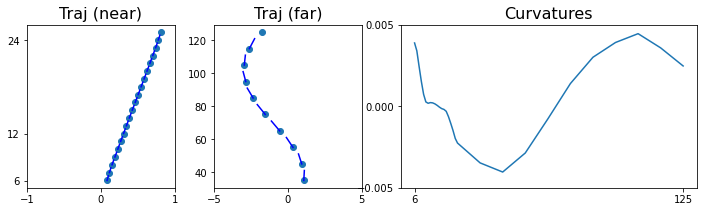

In [696]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

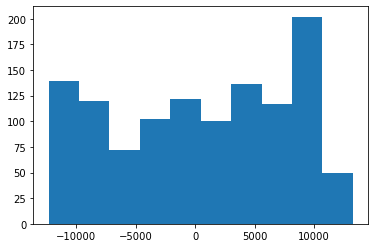

In [697]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

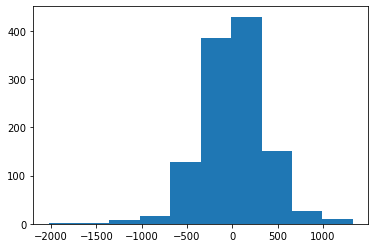

In [698]:
plt.hist(torque[1:]-torque[:-1])[2]

In [699]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [700]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim/for_model_5.17.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = cv2.imread(img_paths[i])
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
    
    img[:,-80:,:] = np.fliplr(maps[i])
    
    video.write(img)
    
video.release()

In [131]:
import numpy as np
a = np.random.uniform(size=(10, 2))
b = np.random.uniform(size=(10, 2))*100

In [132]:
a, b

(array([[0.68073338, 0.8495805 ],
        [0.01327513, 0.33507475],
        [0.14133814, 0.75529615],
        [0.11673258, 0.72184098],
        [0.44272834, 0.45171162],
        [0.96179968, 0.5271258 ],
        [0.49370869, 0.87869405],
        [0.47860206, 0.50659798],
        [0.5391664 , 0.07687142],
        [0.87735747, 0.85768627]]),
 array([[14.04456682, 22.25044061],
        [80.65422516,  7.9128389 ],
        [87.54508612, 91.04162513],
        [65.72227062, 26.55470521],
        [25.38089784, 73.61975071],
        [75.90810219, 24.04939706],
        [92.9446904 ,  6.12541378],
        [10.57507171, 76.91635523],
        [36.5727505 , 82.43988902],
        [32.13177682, 64.07013318]]))

In [133]:
(a[:, None, :] - b[None, :, :])[:,:,0]

array([[-13.36383344, -79.97349179, -86.86435274, -65.04153725,
        -24.70016446, -75.22736881, -92.26395702,  -9.89433833,
        -35.89201712, -31.45104345],
       [-14.03129169, -80.64095003, -87.53181099, -65.70899549,
        -25.36762271, -75.89482706, -92.93141527, -10.56179658,
        -36.55947537, -32.11850169],
       [-13.90322868, -80.51288702, -87.40374798, -65.58093248,
        -25.2395597 , -75.76676405, -92.80335226, -10.43373357,
        -36.43141236, -31.99043868],
       [-13.92783424, -80.53749258, -87.42835354, -65.60553804,
        -25.26416526, -75.79136961, -92.82795782, -10.45833913,
        -36.45601792, -32.01504425],
       [-13.60183848, -80.21149683, -87.10235778, -65.27954229,
        -24.9381695 , -75.46537386, -92.50196207, -10.13234337,
        -36.13002216, -31.68904849],
       [-13.08276714, -79.69242548, -86.58328644, -64.76047094,
        -24.41909816, -74.94630251, -91.98289072,  -9.61327203,
        -35.61095082, -31.16997714],
       [-1

In [115]:
result = (a[:, None, :] - b[None, :, :])**2
result = np.sqrt(result[:,:,0] + result[:,:,1])

In [116]:
a.shape, a[:, None, :].shape

((10, 2), (10, 1, 2))

In [117]:
result.shape

(10, 10)

In [134]:
argmin_ix_a, argmin_ix_b = np.unravel_index(result.argmin(), result.shape)

In [94]:
result

array([[[0.61236404, 0.40687308],
        [0.28589934, 0.03259077],
        [0.4796335 , 0.02863356],
        [0.17218078, 0.0971993 ],
        [0.11575922, 0.08696651],
        [0.25950823, 0.51240421],
        [0.28756368, 0.35079809],
        [0.16448993, 0.12984462],
        [0.15371849, 0.16174685],
        [0.58716339, 0.38283129]],

       [[0.75993099, 0.64907695],
        [0.13833239, 0.27479465],
        [0.62720045, 0.21357031],
        [0.31974773, 0.14500457],
        [0.03180773, 0.15523736],
        [0.40707518, 0.27020034],
        [0.13999673, 0.10859422],
        [0.31205688, 0.37204849],
        [0.30128544, 0.08045702],
        [0.73473034, 0.62503517]],

       [[0.68538001, 0.42178949],
        [0.21288336, 0.04750719],
        [0.55264947, 0.01371715],
        [0.24519675, 0.08228289],
        [0.04274325, 0.0720501 ],
        [0.33252421, 0.4974878 ],
        [0.21454771, 0.33588168],
        [0.2375059 , 0.14476103],
        [0.22673447, 0.14683044],
        [0

In [440]:
wp_xs = -np.array([0, 1, 2, 3])
wp_ys = -np.array([1, 1, 2, 0])

In [442]:
wp_xs **2

array([0, 1, 4, 9])

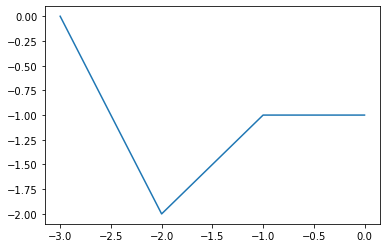

In [412]:
plt.plot(wp_xs, wp_ys)

In [380]:
def get_angles_to(xs, ys, heading):
    # wps w respect to current pos, ie pos already subtracted out. Radians in and out.
    # current heading can be range 0 to 2*pi or -pi to pi
    
    angles = np.arctan2(xs, ys) # from -pi to pi, zero is up
    
    angles[angles<0] += 2*np.pi # rotate to range 0 to 2*pi
    
    angles -= heading # subtract out current heading
    
    angles[angles<-np.pi] += 2*np.pi # rotate into range -pi to pi
    angles[angles>np.pi] -= 2*np.pi
    
    return angles

In [386]:
xs = [0, 1, 1, 1, 0, -1, -1, -1, -0.000001]
ys = [1, 1, 0, -1, -1, -1, 0, 1, 1]
angles = get_angles_to(np.array([-1]),np.array([-1]),0)
angles

array([-2.35619449])

In [379]:
get_angles_to(xs, ys, np.pi)

array([-3.14159265, -2.35619449, -1.57079633, -0.78539816,  0.        ,
        0.78539816,  1.57079633,  2.35619449,  3.14159165])

In [390]:
xs = np.array([2.97412607])
ys = np.array([0.53678649])
heading = 0.18921501426133513
#0.010655776540231567 1.2030181966193643
get_angles_to(ys, xs, heading)

array([-0.0106519])

In [220]:
from viz_utils import make_vid

imgs = np.stack([cv2.imread(f)[:,:,::-1] for f in img_paths]).astype(np.uint8)

for i in range(len(imgs)):
    imgs[i,:,-MAP_WIDTH:,:] = np.fliplr(maps[i])

aux_vid = aux.copy()
#aux_vid[:,:2] = 0 # zeroing out pitch and yaw

run_id = "sim"
model_stem = "9.24_avg"
rollout_data = make_vid(run_id, model_stem, imgs, aux_vid, targets=targets, add_charts=False)

(1160, 30) (1160, 1, 15, 80) (1160, 1, 15, 80)
240 690 3


/home/beans/bespoke/viz_utils.py:59: RuntimeWarning: invalid value encountered in true_divide
  act_grad = act_grad/m


Made vid!


In [19]:
combine_vids("8.9_avg", "8.9_avgTrain", "sim")

combined!


In [267]:
#p = get_viz_rollout(model_stem, imgs, aux_vid, do_gradcam=False)
#wp_angles_all, wp_headings_all, wp_curvatures_all, _, _, _, _, _ = p

In [20]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

(array([ 179.,  417.,  706., 2015.,  961.,  553.,  718.,  156.,   59.,
          36.]),
 array([-0.0455819 , -0.0341057 , -0.02262951, -0.01115332,  0.00032287,
         0.01179907,  0.02327526,  0.03475145,  0.04622764,  0.05770383,
         0.06918003], dtype=float32),
 <BarContainer object of 10 artists>)

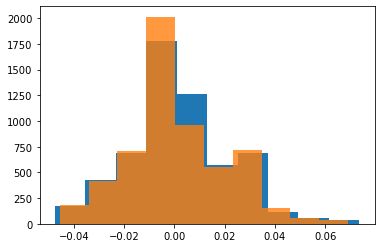

In [21]:
plt.hist(targets[:,:5].flatten())
plt.hist(wp_angles_all[:,:5].flatten(), alpha=.8)

In [22]:
obsnet_outs.shape

(1160, 3)

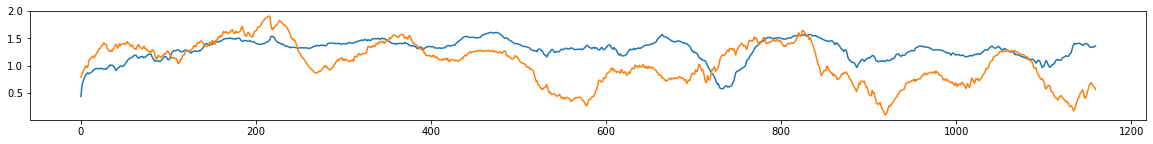

In [23]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])
plt.plot(obsnet_outs[:,2])

In [24]:
aux[0]

array([7.9585475e-01, 1.5869594e+00, 4.5101814e+01, 0.0000000e+00,
       3.2588083e-03], dtype=float32)

In [261]:
all_aux = []
all_wp_angles = []
all_wp_dists = []
all_run_paths = []
n_couldnt_load_runs = 0
for d in range(N_RUNNERS):
    datagen_id = ("00"+str(d))[-2:]
    for r in range(RUNS_TO_STORE_PER_PROCESS):
        run_path = f"/home/beans/blender_membank/dataloader_{datagen_id}/run_{r}"
        n_targets_paths_files = len(glob.glob(f"{run_path}/targets_*.npy"))
        targets_paths = [f'{run_path}/targets_{i}.npy' for i in chunks_range]
        
        if n_targets_paths_files < len(targets_paths):
            n_couldnt_load_runs += 1
            continue
            
        aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
        targets = np.concatenate([np.load(p) for p in targets_paths], axis=0)
        
        wp_angles, wp_dists, wp_zs = np.split(targets, 3, axis=1)
        
        all_aux.append(aux)
        all_wp_angles.append(wp_angles)
        all_wp_dists.append(wp_dists)
        all_run_paths.append(run_path)
        
all_aux = np.stack(all_aux, axis=0)
all_wp_angles = np.stack(all_wp_angles, axis=0)
all_wp_dists = np.stack(all_wp_dists, axis=0)

print(f"couldn't load {n_couldnt_load_runs} out of {N_RUNNERS*RUNS_TO_STORE_PER_PROCESS} runs")

couldn't load 12 out of 360 runs


In [93]:
%%time
all_headings = get_headings_from_traj_batch(all_wp_angles, all_wp_dists)

CPU times: user 6.45 s, sys: 0 ns, total: 6.45 s
Wall time: 6.44 s


In [94]:
all_curvatures = get_curvatures_from_headings_batch(all_headings)

In [95]:
all_wp_angles.shape, all_wp_dists.shape, all_headings.shape, all_curvatures.shape

((348, 1160, 30), (348, 1160, 30), (348, 1160, 30), (348, 1160, 30))

In [96]:
mm = 0
for i in range(len(all_curvatures)):
    m = abs(all_curvatures[i]).max()
    if m > .05:
        print(i, m)
        mm += 1

30 0.061482668
35 0.057456672
36 0.14816466
38 0.061911583
132 0.14244005
138 0.08136749
139 0.060184345
142 0.07117872
175 0.050268054
184 0.08510129
241 0.057906955
258 0.058204323
287 0.061904952
293 0.06905866
297 0.099907696
329 0.06680691
336 0.076619744


In [97]:
all_run_paths[36]

'/home/beans/blender_membank/dataloader_01/run_8'

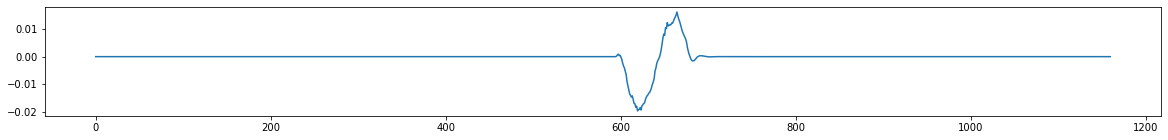

In [98]:
plt.figure(figsize=(20,2))
plt.plot(all_wp_angles[94,:,0])

<BarContainer object of 40 artists>

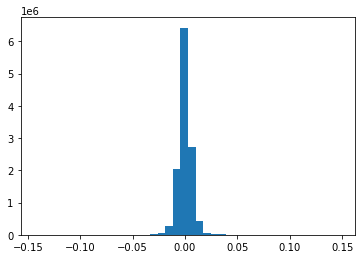

In [99]:
plt.hist(all_curvatures[:,:,:].flatten(), bins=40)[2]

In [100]:
all_torques = []
all_tds = []
for i in range(len(all_aux)):
    speeds = all_aux[i, :, 2]
    wp_angles = gather_preds(all_wp_angles[i, :, :], speeds)
    torque = np.degrees(wp_angles) * speeds**2
    all_torques.append(torque)
    all_tds.append(torque[1:]-torque[:-1])
    
all_torques = np.concatenate(all_torques)
all_tds = np.concatenate(all_tds)

<BarContainer object of 40 artists>

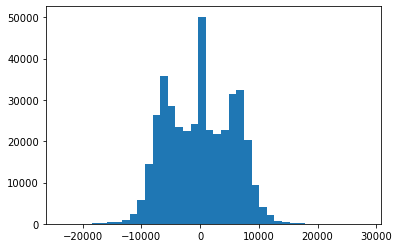

In [101]:
plt.hist(all_torques.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

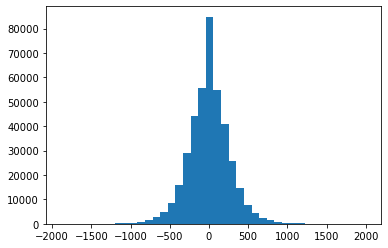

In [102]:
plt.hist(all_tds.flatten(), bins=40)[2]

In [103]:
np.quantile(abs(all_tds.flatten()), .999), np.quantile(abs(all_torques.flatten()), .999)

(1213.0810891947276, 16951.596545054446)

In [104]:
mean_dists = abs(all_wp_dists).mean(axis=0).mean(0)
mean_dists

array([  5.9956417,   6.9946885,   7.993679 ,   8.992583 ,   9.991397 ,
        10.990128 ,  11.988702 ,  12.987193 ,  13.985542 ,  14.983733 ,
        15.981789 ,  16.979698 ,  17.977406 ,  18.97495  ,  19.972319 ,
        20.969503 ,  21.966492 ,  22.963268 ,  23.959808 ,  24.956186 ,
        34.90686  ,  44.83198  ,  54.73005  ,  64.60014  ,  74.44254  ,
        84.2583   ,  94.0484   , 103.813736 , 113.55613  , 123.27644  ],
      dtype=float32)

<BarContainer object of 40 artists>

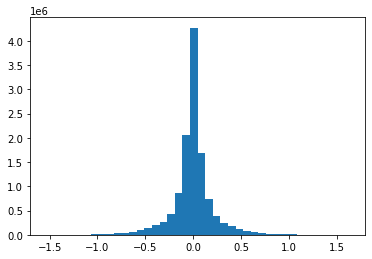

In [105]:
plt.hist(all_headings.flatten(), bins=40)[2]

In [106]:
mean_headings = abs(all_headings).mean(axis=0).mean(0)
mean_headings

array([0.02822183, 0.0326863 , 0.03705886, 0.04143412, 0.04581281,
       0.05018519, 0.05453863, 0.05887541, 0.06319571, 0.06749909,
       0.07178165, 0.0760383 , 0.08027021, 0.08447491, 0.08864769,
       0.09278919, 0.09690095, 0.10098111, 0.10502793, 0.1089357 ,
       0.14578015, 0.17967056, 0.2094137 , 0.2350533 , 0.2568414 ,
       0.2750846 , 0.2901327 , 0.30220774, 0.3113808 , 0.3161817 ],
      dtype=float32)

In [107]:
mean_headings[-1] / mean_headings[0]

11.203445

In [108]:
mean_angles = abs(all_wp_angles).mean(axis=0).mean(0)
mean_angles

array([0.01769507, 0.01949322, 0.02139211, 0.02335472, 0.02536031,
       0.02739682, 0.02945474, 0.03152686, 0.03360902, 0.03569776,
       0.03779066, 0.03988507, 0.04197887, 0.04407034, 0.0461583 ,
       0.04824146, 0.0503193 , 0.05239039, 0.05445384, 0.05650889,
       0.0764754 , 0.09516597, 0.11238024, 0.1280391 , 0.14216535,
       0.15478034, 0.16592038, 0.17569119, 0.18420565, 0.1915262 ],
      dtype=float32)

In [109]:
mean_angles[-1] / mean_angles[0]

10.823705

In [110]:
mean_angles[0] / .015

1.179671287536621

<BarContainer object of 40 artists>

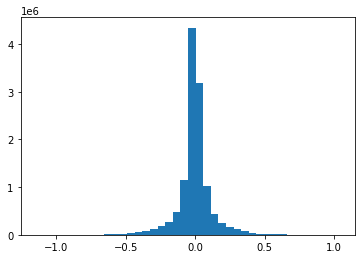

In [111]:
plt.hist(all_wp_angles.flatten(), bins=40)[2]

<BarContainer object of 40 artists>

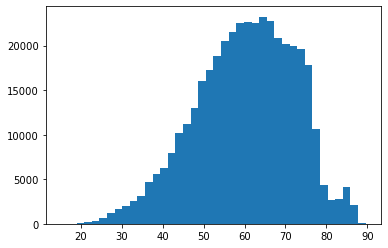

In [112]:
# speed
plt.hist(all_aux[:,:,2].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

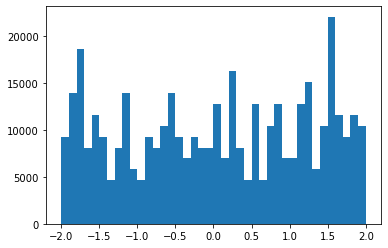

In [113]:
# pitch
plt.hist(all_aux[:,:,0].flatten(), bins=40)[2]

<BarContainer object of 40 artists>

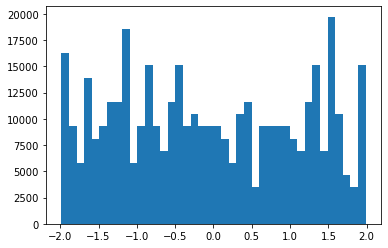

In [114]:
# yaw
plt.hist(all_aux[:,:,1].flatten(), bins=40)[2]